In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,  GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
sp500 = pd.read_csv('../Data/sp500_main.csv')
macro = pd.read_csv('../Data/macro_data.csv')

In [3]:
macro= macro.set_index('Date')
sp500 = sp500.set_index('Date')

In [4]:
# Loop through each unique ticker (stock) in the DataFrame
indicator = pd.DataFrame()
for ticker in sp500.columns:
    # Calculate SMAs 
    indicator[f'{ticker}_SMA3'] = sp500[ticker].rolling(window=3).mean()
    indicator[f'{ticker}_SMA20'] = sp500[ticker].rolling(window=20).mean()
    indicator[f'{ticker}_SMA50'] = sp500[ticker].rolling(window=50).mean()
    indicator[f'{ticker}_SMA100'] = sp500[ticker].rolling(window=100).mean()
    indicator[f'{ticker}_SMA200'] = sp500[ticker].rolling(window=200).mean()
    
    # Calculate EMA
    indicator[f'{ticker}_EMA3'] = sp500[ticker].ewm(span=3, adjust=False).mean()
    indicator[f'{ticker}_EMA12'] = sp500[ticker].ewm(span=12, adjust=False).mean()
    indicator[f'{ticker}_EMA26'] = sp500[ticker].ewm(span=26, adjust=False).mean()
    
    # Calculate MACD
    indicator[f'{ticker}_MACD'] = indicator[f'{ticker}_EMA12'] - indicator[f'{ticker}_EMA26']
    
    # Calculate Signal line (9-day EMA of the MACD)
    indicator[f'{ticker}_signal'] = indicator[f'{ticker}_MACD'].ewm(span=9, adjust=False).mean()
    
    # Concatenate each ticker's results into the final indicator DataFrame
    indicator = pd.concat([indicator, sp500], axis=1)

In [5]:
indicator = indicator.dropna()

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Merge all the files that have X-variable (features)
features_df = pd.merge(macro, indicator, on='Date', how='outer')
features_df = features_df.fillna(method='ffill').dropna()

In [7]:
# drop the same column names
features_df = features_df.loc[:, ~features_df.columns.duplicated()]

In [8]:
# Make the rows number the same with target and features files
# set the index to the format Datetime
sp500.index = pd.to_datetime(sp500.index)
features_df.index = pd.to_datetime(features_df.index)

# Align the two DataFrames by finding the intersection of their indices
common_index = sp500.index.intersection(features_df.index)

# Reindex both DataFrames to the common index
sp500 = sp500.loc[common_index]
features_df = features_df.loc[common_index]

In [9]:
features_df.shape, sp500.shape

((2556, 224), (2556, 20))

In [10]:
# define X and y
X = features_df 
y = sp500 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Training set shape for AAPL: X_train: (2196, 224), y_train: (2196,)
Testing set shape for AAPL: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Hyperparameters for AAPL: {'alpha': 0, 'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Performance for AAPL - RMSE: 23.378056583006252


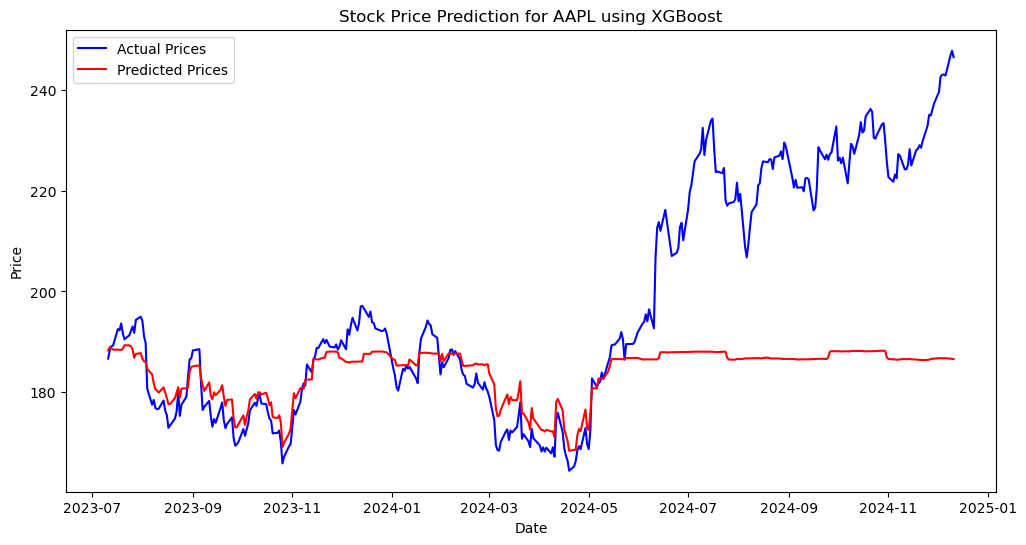

Training set shape for AMZN: X_train: (2196, 224), y_train: (2196,)
Testing set shape for AMZN: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Hyperparameters for AMZN: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Performance for AMZN - RMSE: 8.516337019312688


<Figure size 640x480 with 0 Axes>

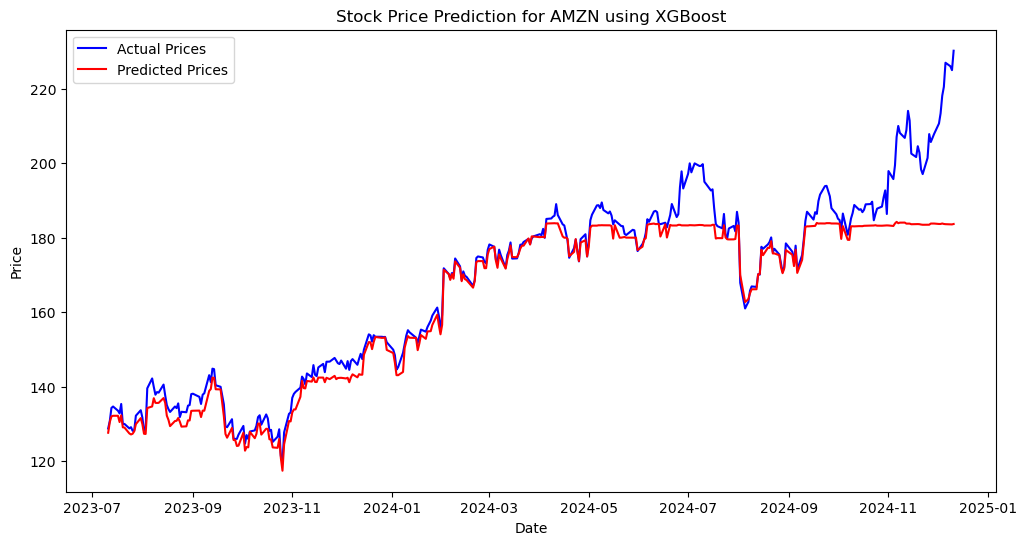

Training set shape for AVGO: X_train: (2196, 224), y_train: (2196,)
Testing set shape for AVGO: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Hyperparameters for AVGO: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200}
Performance for AVGO - RMSE: 59.369759265204365


<Figure size 640x480 with 0 Axes>

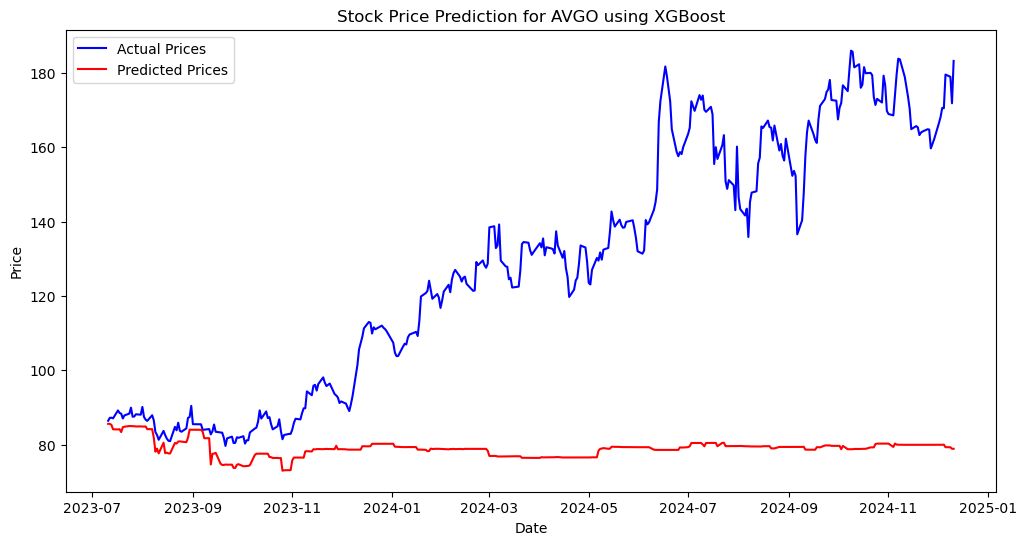

Training set shape for COST: X_train: (2196, 224), y_train: (2196,)
Testing set shape for COST: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Hyperparameters for COST: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Performance for COST - RMSE: 212.0918094700688


<Figure size 640x480 with 0 Axes>

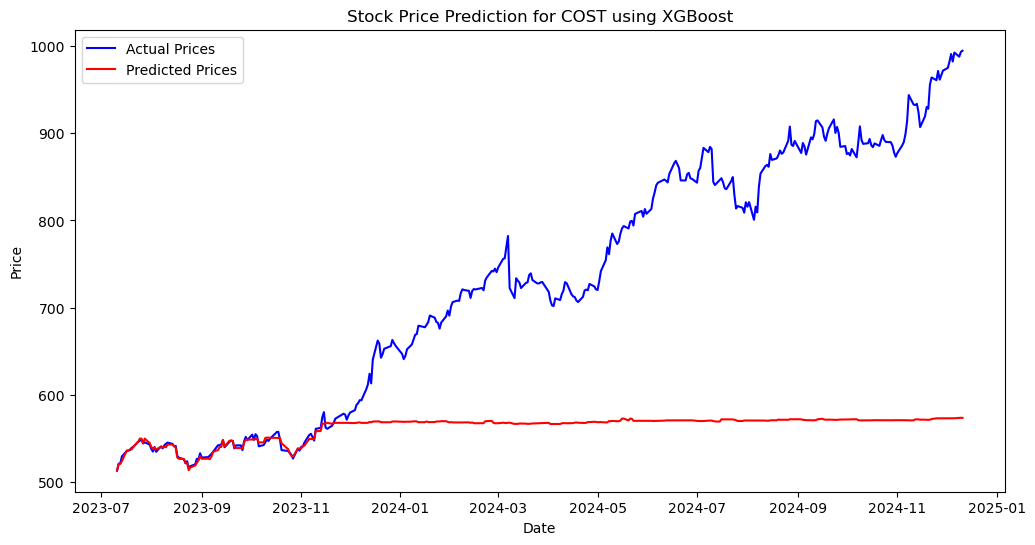

Training set shape for GOOG: X_train: (2196, 224), y_train: (2196,)
Testing set shape for GOOG: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Hyperparameters for GOOG: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Performance for GOOG - RMSE: 16.070088448592724


<Figure size 640x480 with 0 Axes>

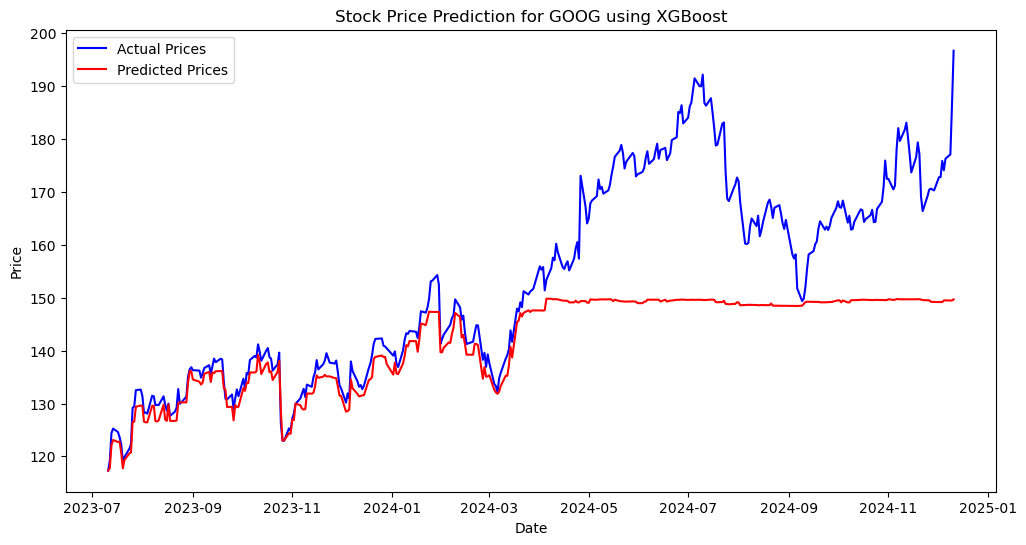

Training set shape for GOOGL: X_train: (2196, 224), y_train: (2196,)
Testing set shape for GOOGL: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


In [ ]:
# Initialize dictionaries to store results
results = {}

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'alpha': [0, 10, 20]
}

# Fixed test size for the last 360 rows
test_size = 360

# Loop through each stock in the sp500 DataFrame
for stock in sp500.columns:
    
    # Prepare the target (stock price) for each stock
    y_stock = sp500[stock]  # Stock price for this particular stock
    
    # Define training and testing sets
    X_train = features_df.iloc[:-test_size, :]
    X_test = features_df.iloc[-test_size:, :]
    y_train = y_stock.iloc[:-test_size]
    y_test = y_stock.iloc[-test_size:]
    
    # Print dataset shapes
    print(f"Training set shape for {stock}: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set shape for {stock}: X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Initialize the XGBoost regressor
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, 
                               cv=3, scoring='neg_mean_squared_error', verbose=1)
    
    # Fit the GridSearchCV model to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters for {stock}: {best_params}")
    
    # Use the best estimator found by GridSearchCV to make predictions
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test data
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    print(f'Performance for {stock} - RMSE: {rmse}')
    
    # Store the results (model, predictions, evaluation metrics)
    results[stock] = {
        'model': best_model, 
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse
    }
    
    # Plot Actual vs Predicted Stock Prices
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, color='blue', label='Actual Prices')
    plt.plot(y_test.index, y_pred, color='red', label='Predicted Prices')
    plt.title(f'Stock Price Prediction for {stock} using XGBoost')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Save the plot
    plt.savefig(f'../images/{stock}_xgboost_prediction.png', format='png')
